### Imports

In [58]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import json

# Future libraries:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

### Data collection
Use online resources to collect data that can convert CO2 to AQI values. AQI calculator exists online, however it is only limited to certain parameters. This will help create the logistic regression model

In [102]:
df = pd.read_csv('sample.log')

In [103]:
# New column headers
def parse_data(input_df, date_experiment=(2024, 1, 1)):
    gas_sensor = [f'GasSensor #{i} V' for i in range(1, 13)]
    camera_pixels = [f'IRCamera Pixels #{i} ºC' for i in range(1, 65)]
    # New labels
    new_columns = [
        *gas_sensor, 'Temperature ºC', 'Pressure Pa', 'Humidity %RH', 'Battery Charge %',
        'Net Current A', 'Tension V', 'Battery Temp ºC', 'PM 1.0 µg/m³', 'PM 2.5 µg/m³',
        'PM 4.0 µg/m³', 'PM 10.0 µg/m³', 'PM 1.0 µg/m³', 'PM 2.5 µg/m³', 'PM 4.0 µg/m³',
        'PM 10.0 µg/m³', 'PM Typ Size µm', 'CO2 ppm', 'Station ID', 'msg counter',
        *camera_pixels, 'Packt CheckSum'
    ]
    # Process
    first_row = input_df.columns
    first_row_df = first_row.to_frame().T.reset_index(drop=True)    
    input_df = pd.concat([first_row_df, input_df], ignore_index=True)
    input_df.columns = new_columns
    
    # Add a column of timestamps that are 15s intervals
    
    # Date experiment is given in year, month, day
    spacing = 15
    start_date = datetime(date_experiment[0], date_experiment[1], date_experiment[2])
    timestamps = [start_date + timedelta(seconds=i*spacing) for i in range(len(input_df))]   
    input_df.insert(loc=0, column='Time Stamps', value=timestamps)
    
    # Return
    return input_df 

In [104]:
parse_data(df)

,Time Stamps,GasSensor #1 V,GasSensor #2 V,GasSensor #3 V,GasSensor #4 V,GasSensor #5 V,GasSensor #6 V,GasSensor #7 V,GasSensor #8 V,GasSensor #9 V,...,IRCamera Pixels #56 ºC,IRCamera Pixels #57 ºC,IRCamera Pixels #58 ºC,IRCamera Pixels #59 ºC,IRCamera Pixels #60 ºC,IRCamera Pixels #61 ºC,IRCamera Pixels #62 ºC,IRCamera Pixels #63 ºC,IRCamera Pixels #64 ºC,Packt CheckSum
0,2024-01-01 00:00:00,-0.567066,0.534685,0.429450,-0.335766,0.450423,-0.328523,0.493384,-0.206982,0.394445,...,14.26,15.28,15.29,15.30,15.31,15.32,14.27,14.28,14.29,215
1,2024-01-01 00:00:15,-0.567222,0.536036,0.429491,-0.335958,0.450594,-0.32862,0.493277,-0.206909,0.394705,...,14,14,15,15,15,15,15,14,13,146
2,2024-01-01 00:00:30,-0.566803,0.536476,0.429816,-0.33609,0.450983,-0.328509,0.493344,-0.207815,0.394276,...,14,15,15,15,15,15,15,15,14,211
3,2024-01-01 00:00:45,-0.567058,0.53642,0.429712,-0.336016,0.450695,-0.328626,0.493615,-0.206926,0.393988,...,14,15,15,15,15,15,15,14,13,143
4,2024-01-01 00:01:00,-0.56683,0.536593,0.429909,-0.336115,0.451058,-0.328863,0.493175,-0.207109,0.394895,...,14,15,15,15,15,15,15,14,14,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2024-01-01 00:16:45,-0.567766,0.539755,0.431691,-0.337616,0.449515,-0.328548,0.493154,-0.210064,0.393266,...,12,13,14,14,14,14,14,14,12,198
68,2024-01-01 00:17:00,-0.5681,0.538896,0.431838,-0.33757,0.448723,-0.32842,0.492898,-0.210132,0.393935,...,13,14,14,14,14,14,14,13,12,158
69,2024-01-01 00:17:15,-0.567998,0.539165,0.431963,-0.337678,0.449463,-0.328302,0.492827,-0.208606,0.394298,...,13,14,14,14,14,14,14,14,12,55
70,2024-01-01 00:17:30,-0.56788,0.538843,0.431898,-0.337753,0.449489,-0.32827,0.493254,-0.209786,0.394309,...,14,14,14,14,14,14,14,14,12,221


# Exploratory Data Analysis

### Cleaning Data
#### For now I am going to assume the data is in perfect shape. Once we actually get real data I am going to modify this

In [195]:
df.drop(['GasSensor', 'IRCameraPixels'], axis=1, inplace=True)
features = df.columns

#### Soon when we collect real data, it would be beneficial to create additional variables or use feature engineering to be able to create a model that can predict the liklihood of a wildfire 

In [196]:
df.head()

,Timestamp,Temperature,Pressure,Humidity,BatteryCharge,NetCurrent,Tension,BatteryTemp,PM1.0,PM2.5,...,PM10.0,PM1.0_1/cm3,PM2.5_1/cm3,PM4.0_1/cm3,PM10.0_1/cm3,PMTypSize,CO2,StationID,MsgCounter,PacktCheckSum
0,2022-01-01 00:00:00,21.871135,104515.177509,65.520433,83.117207,-1.128363,3.817853,22.122549,44.667148,21.878068,...,137.148746,157.527326,734.787318,2467.477130,629.656802,7.553400,418.796358,1,92,125
1,2022-01-01 00:00:02,26.149622,103484.731233,25.854750,83.784752,0.803510,3.868300,20.332644,30.571540,87.128764,...,185.329882,533.221002,325.010312,617.796451,1235.367342,4.967621,483.921372,9,50,68
2,2022-01-01 00:00:04,28.888988,96721.567755,22.414686,96.160295,0.797381,4.095355,23.723969,5.785665,5.297177,...,156.826452,164.775887,502.931941,2597.122817,2812.025931,5.935501,371.383474,9,6,199
3,2022-01-01 00:00:06,21.338502,93395.538795,65.194185,85.216622,-0.507754,4.152125,32.558367,25.546529,78.219509,...,145.575524,429.491679,429.467005,1493.276817,2603.220970,8.989482,439.027595,4,30,72
4,2022-01-01 00:00:08,28.906791,101615.221839,45.521316,95.984542,-0.113942,4.150757,36.040230,24.862716,61.581890,...,82.812388,408.712523,1463.320039,1098.460388,364.158677,1.980996,429.733094,8,74,197


In [197]:
df.tail()

,Timestamp,Temperature,Pressure,Humidity,BatteryCharge,NetCurrent,Tension,BatteryTemp,PM1.0,PM2.5,...,PM10.0,PM1.0_1/cm3,PM2.5_1/cm3,PM4.0_1/cm3,PM10.0_1/cm3,PMTypSize,CO2,StationID,MsgCounter,PacktCheckSum
995,2022-01-01 00:33:10,19.745294,93509.099404,21.040756,94.688946,0.105318,4.193487,21.126580,37.729860,94.536797,...,144.368550,199.630649,1895.575030,121.166973,3675.658388,5.014374,401.455953,4,98,141
996,2022-01-01 00:33:12,23.298298,106124.193103,79.639864,90.020411,-0.400610,4.117324,35.713555,34.444655,72.941999,...,46.819584,268.706620,32.735528,1690.548058,2401.863253,3.739350,310.321671,9,10,38
997,2022-01-01 00:33:14,23.871387,107768.634103,52.612414,92.087229,0.228102,4.024710,32.197990,6.660930,55.814273,...,194.994913,439.963150,1648.198579,365.015679,2926.451277,2.237640,364.243260,7,88,1
998,2022-01-01 00:33:16,27.278235,107025.776786,48.417845,86.055472,-0.201025,3.876142,21.290897,25.103229,59.068615,...,132.959398,446.128009,338.275187,945.626978,226.363390,5.574117,424.120536,1,89,61
999,2022-01-01 00:33:18,21.033894,98667.338974,77.277042,84.007206,0.372593,3.823442,24.363212,39.040732,53.899201,...,90.485377,774.411712,784.440457,1984.880585,2241.021820,8.894923,468.211387,6,48,52


In [198]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,24.962677,4.802120,5.387999,21.741250,25.058604,28.093162,39.570546
Pressure,1000.0,99882.328134,5819.288828,90026.672790,94868.658747,99666.338090,105094.896478,109966.063115
Humidity,1000.0,49.985628,17.385288,20.079192,34.542572,49.779611,65.729726,79.988309
BatteryCharge,1000.0,90.070350,5.849052,80.006195,85.037346,90.115871,95.195068,99.998497
NetCurrent,1000.0,0.014147,0.511308,-1.541281,-0.336607,0.032131,0.361070,1.714455
Tension,1000.0,3.855940,0.199038,3.500870,3.688469,3.860045,4.021928,4.199260
BatteryTemp,1000.0,25.050224,5.113342,6.823999,21.753414,25.092940,28.418395,40.702115
PM1.0,1000.0,25.427672,14.334648,0.126088,13.550406,25.110206,38.264855,49.867227
PM2.5,1000.0,50.716258,29.722857,0.249545,24.395091,52.743225,76.189691,99.990098
PM4.0,1000.0,79.028238,43.480751,0.007219,42.352885,80.783542,116.357282,149.948446


#### Useful methods

In [199]:
variable_units = {
    'GasSensor': 'V',
    'Temperature': 'ºC',
    'Pressure': 'Pa',
    'Humidity': '%RH',
    'BatteryCharge': '%',
    'NetCurrent': 'A',
    'Tension': 'V',
    'BatteryTemp': 'ºC',
    'PM1.0': 'µg/m³',
    'PM2.5': 'µg/m³',
    'PM4.0': 'µg/m³',
    'PM10.0': 'µg/m³',
    'PM1.0_1/cm3': '1/cm³',
    'PM2.5_1/cm3': '1/cm³',
    'PM4.0_1/cm3': '1/cm³',
    'PM10.0_1/cm3': '1/cm³',
    'PMTypSize': 'µm',
    'CO2': 'ppm',
    'StationID': '',
    'MsgCounter': '',
    'PacktCheckSum': ''
}

In [200]:
# Expected that values contains the values you want to compare w.r.t time
# Time is every 2 second intervals
# The end value is exclusive
def plot_time_series(timestamps, values, start, end, y_label = '', title='', width=0.5):
    
    # Extract time stamps
    times = pd.to_datetime(timestamps[start:end])
    values = values[start:end]
    # Plot the original series
    plt.figure(figsize=(12, 6))
    plt.plot(times, values, color='blue', label=y_label, linewidth=width)

    plt.title(title)
    plt.xlabel('Time[s]')
    
    if variable_units[y_label] == '':
        plt.ylabel(y_label)            
    else:
        plt.ylabel(y_label + f' ({variable_units[y_label]})')        

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

In [201]:
features

Index(['Timestamp', 'Temperature', 'Pressure', 'Humidity', 'BatteryCharge',
       'NetCurrent', 'Tension', 'BatteryTemp', 'PM1.0', 'PM2.5', 'PM4.0',
       'PM10.0', 'PM1.0_1/cm3', 'PM2.5_1/cm3', 'PM4.0_1/cm3', 'PM10.0_1/cm3',
       'PMTypSize', 'CO2', 'StationID', 'MsgCounter', 'PacktCheckSum'],
      dtype='object')

In [202]:
def display_time_series(start, end):
    for feature in features[1:]:
        plot_time_series(df.Timestamp, df[feature], start, end, y_label=feature, title= f'{feature} vs Time', width=1.0)

In [203]:
# Heatmap to show which features have the strongest correlation
def display_heatmap(cmap='viridis'):
    # Calc corr
    correlation_matrix = df.corr(numeric_only=True)
    # Plotting
    plt.figure(figsize=(8, 6)) # Set figure size
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # Hides upper triangle
    # Correlation matrix, annotating with numbers, cmap, correlation range
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, mask=mask, vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

### Viz

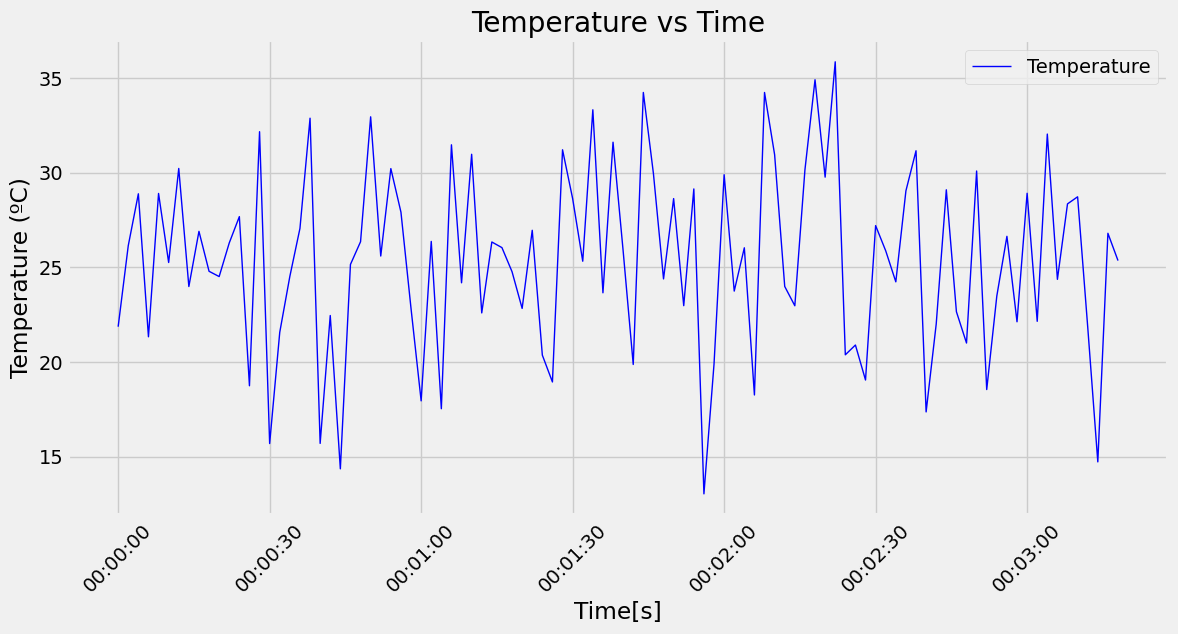

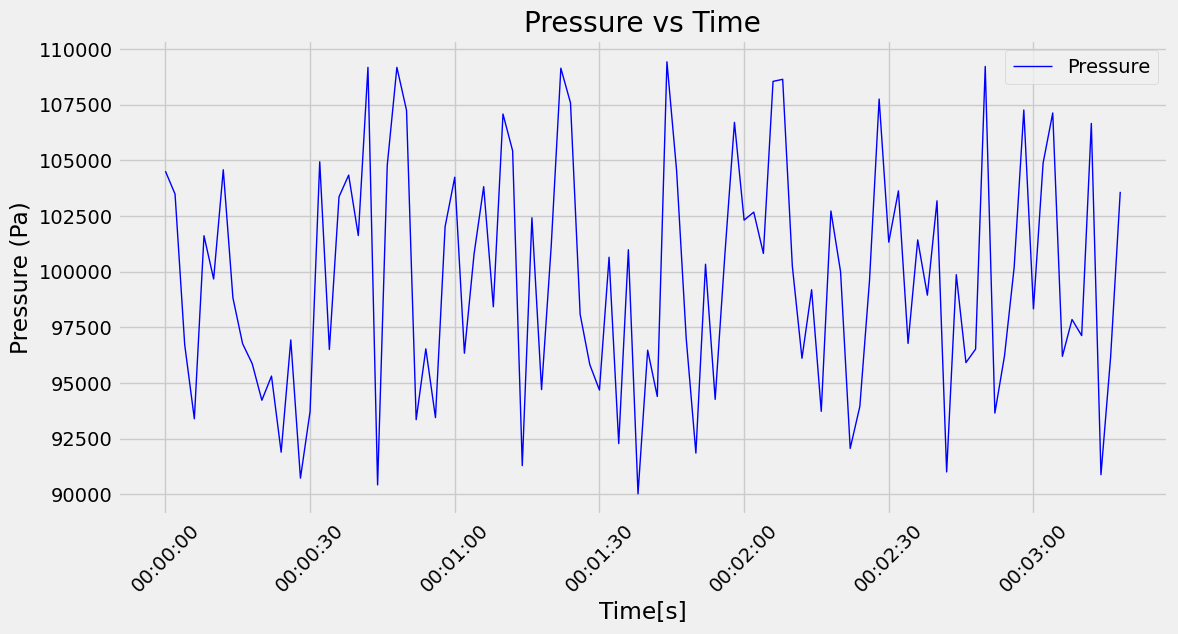

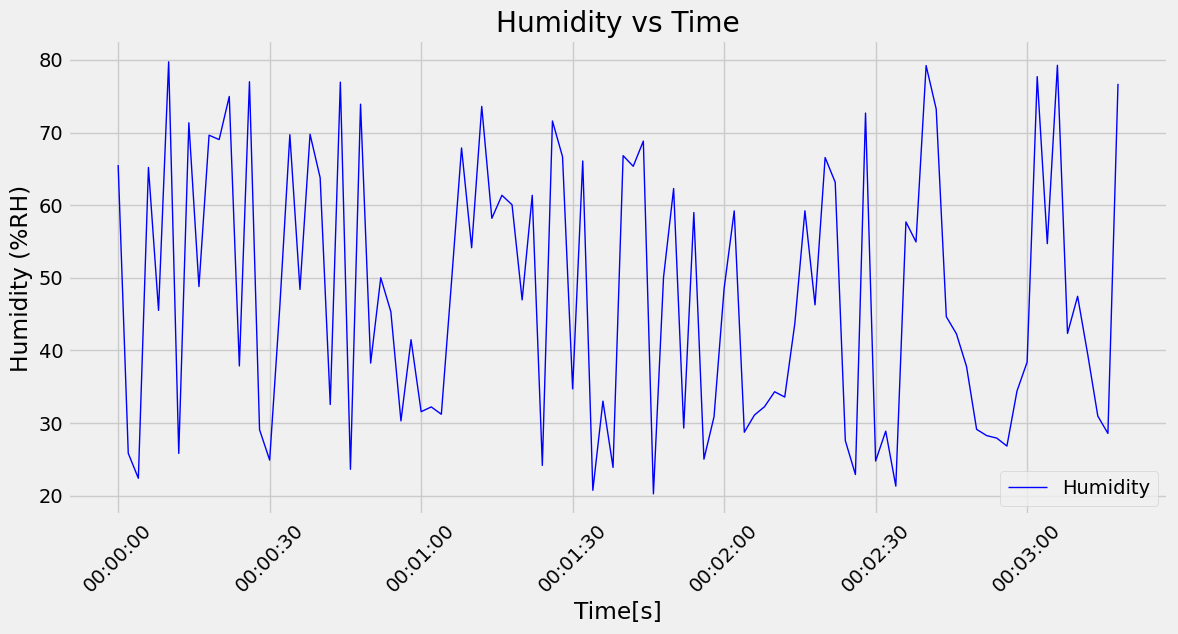

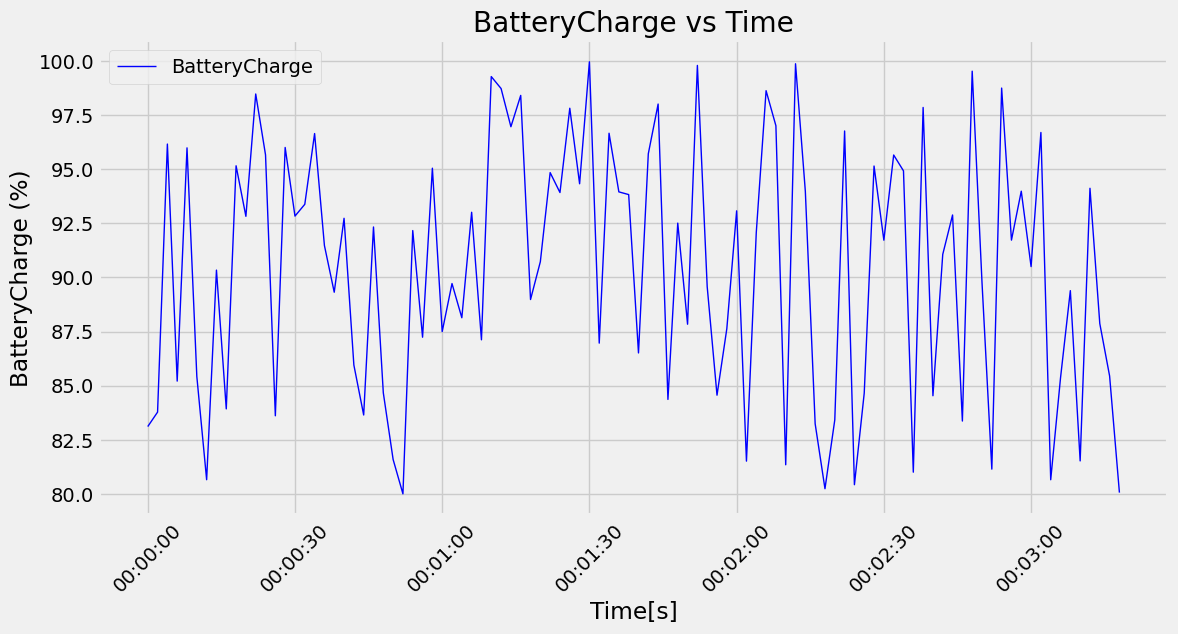

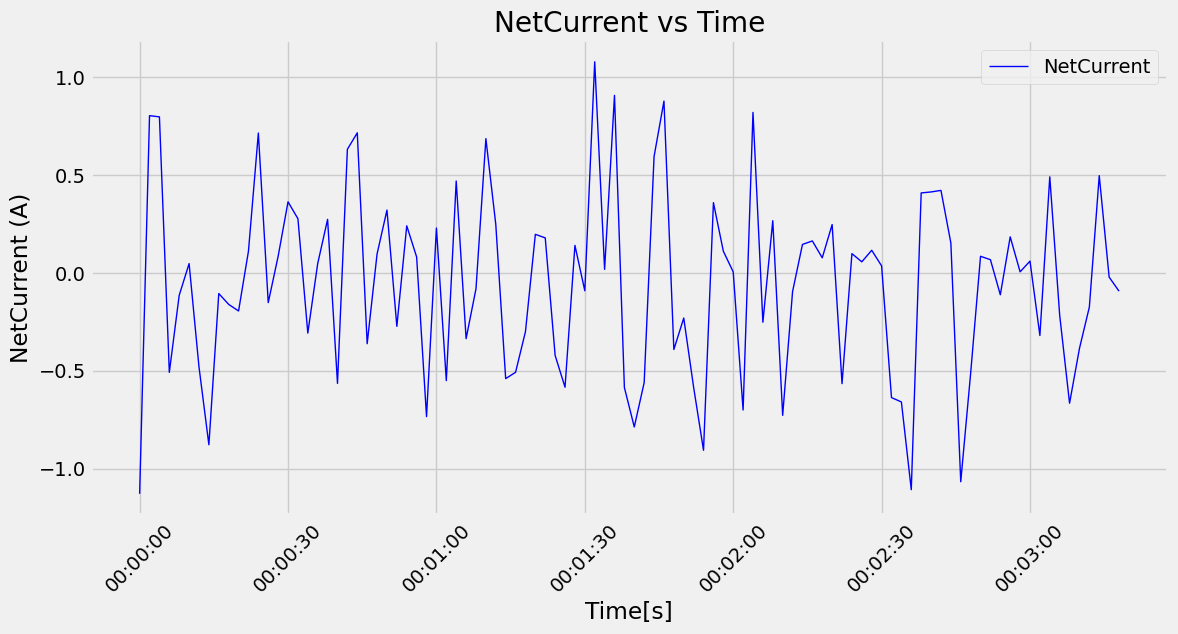

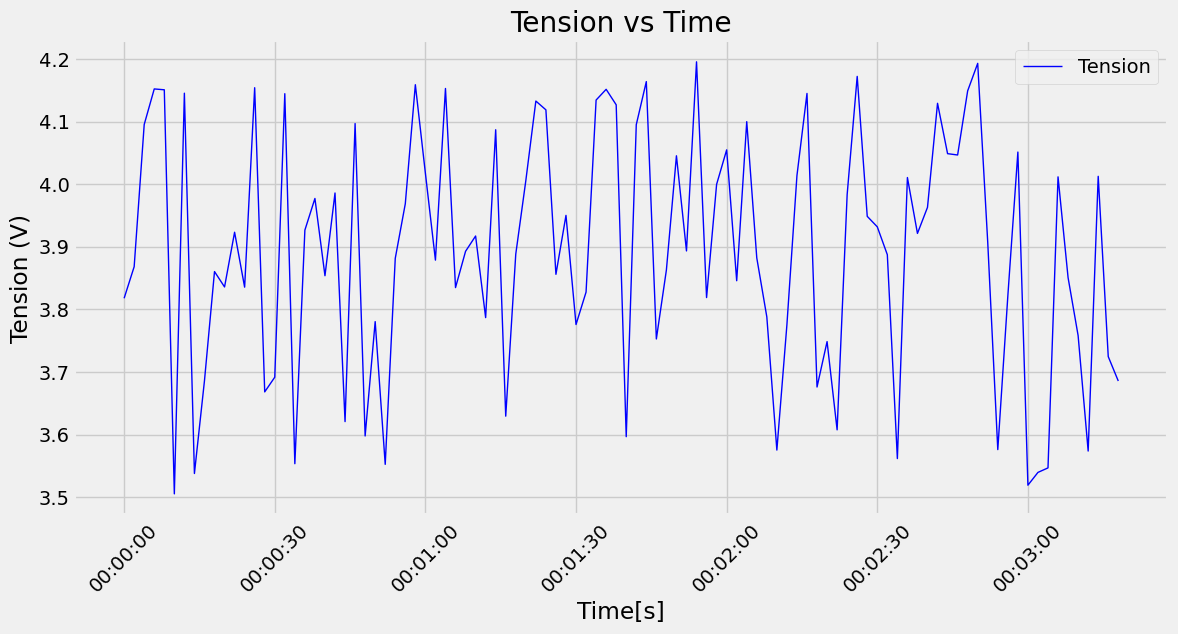

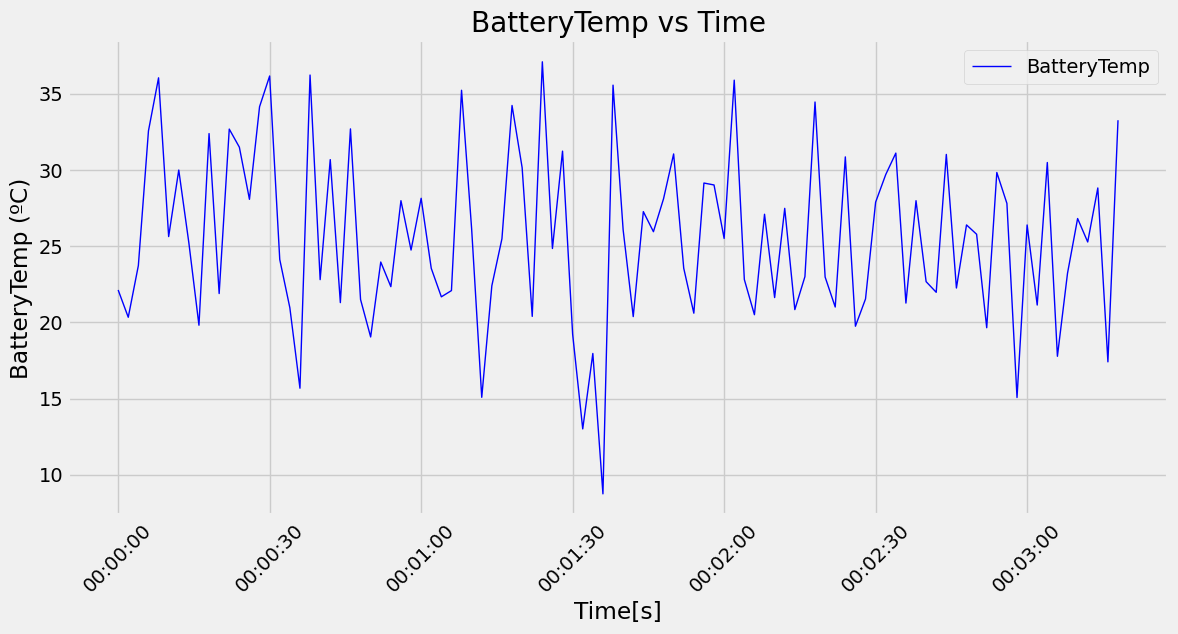

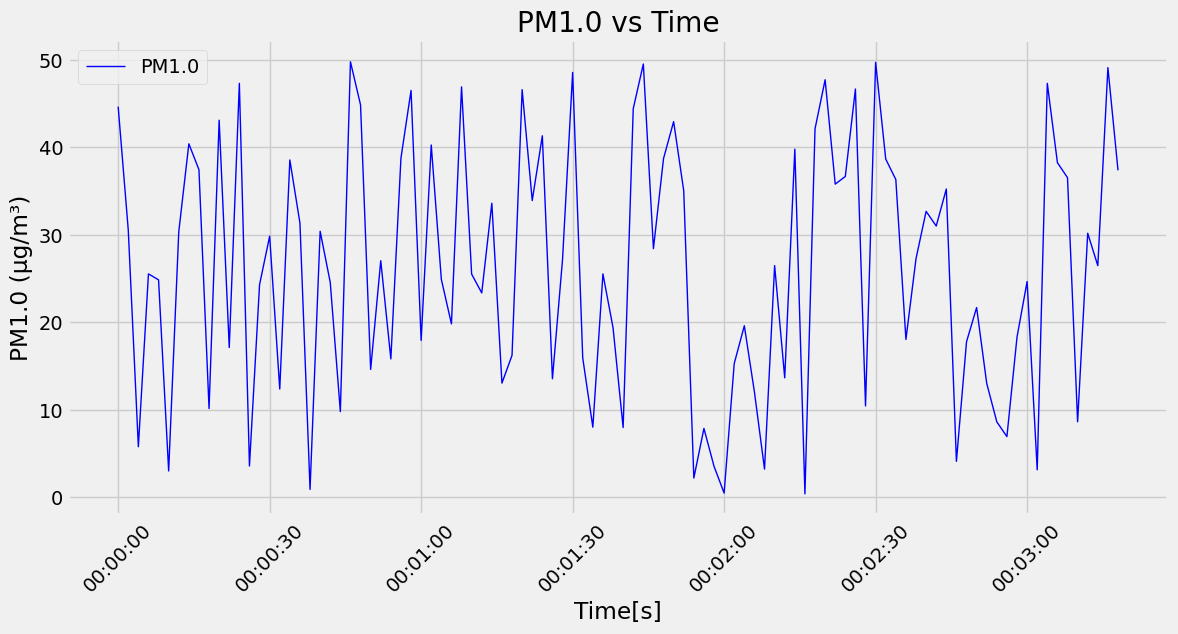

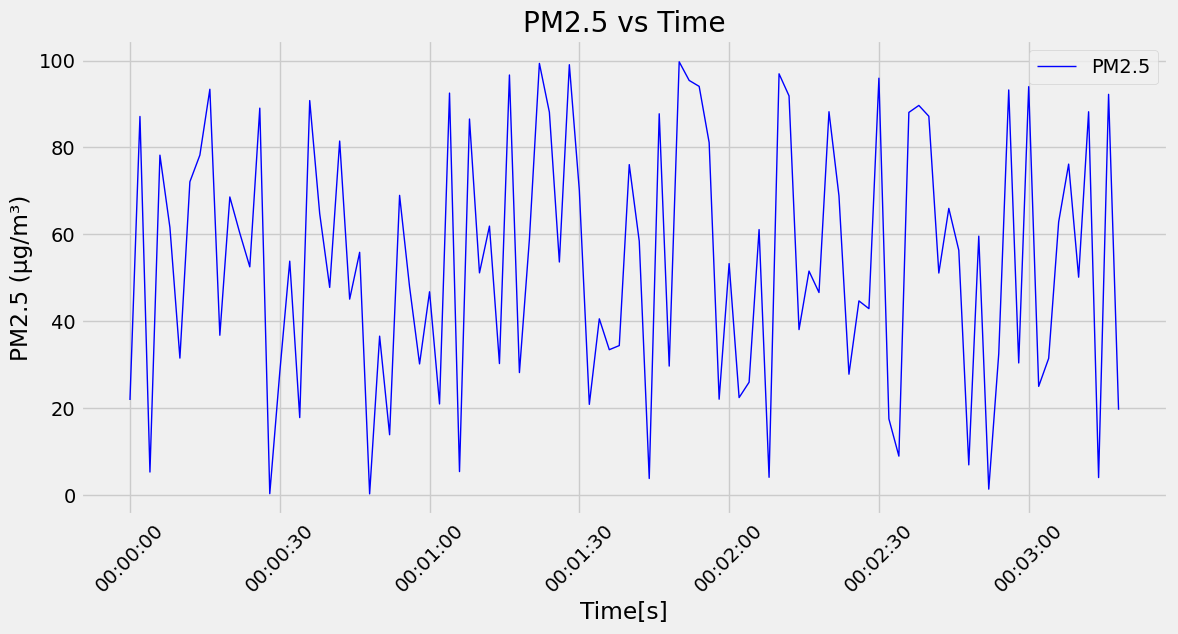

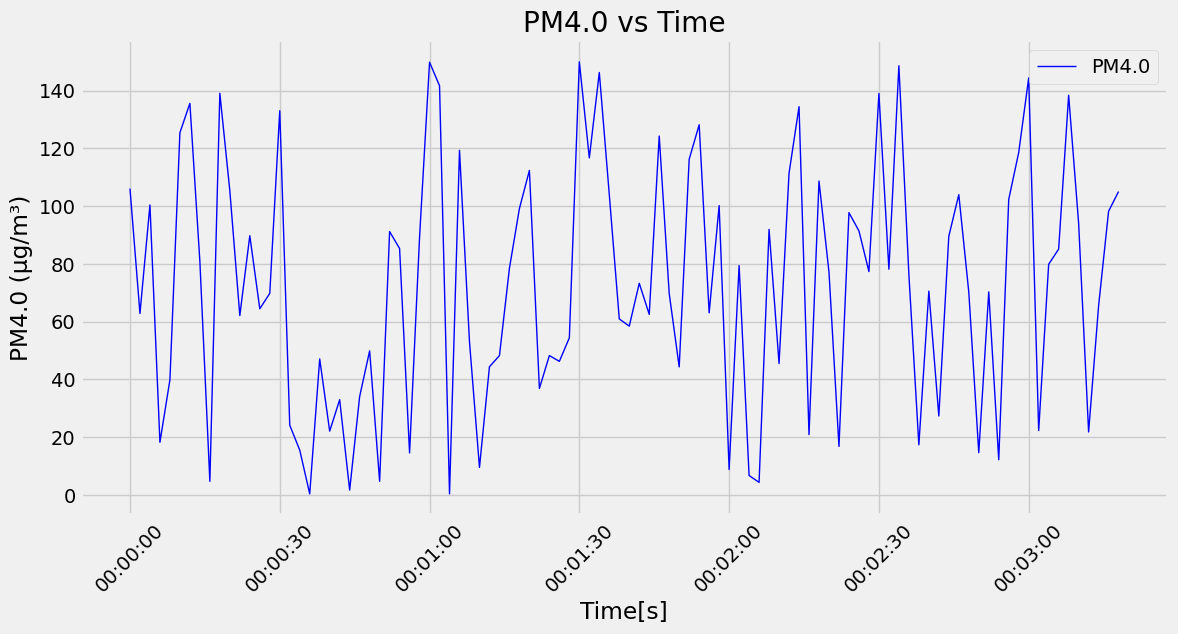

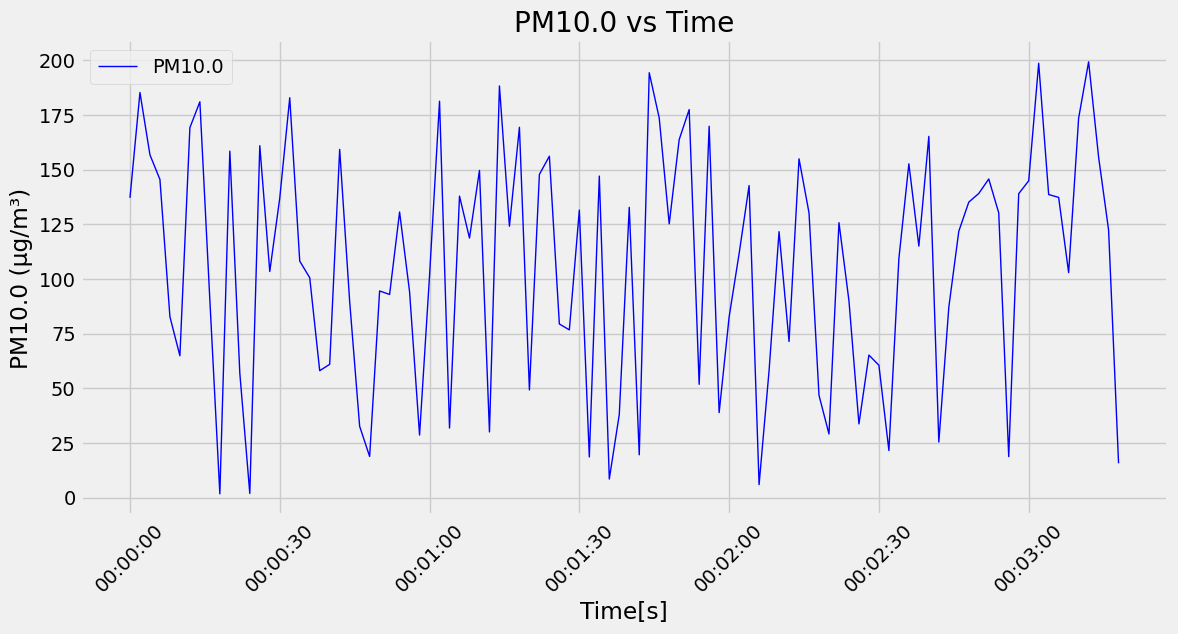

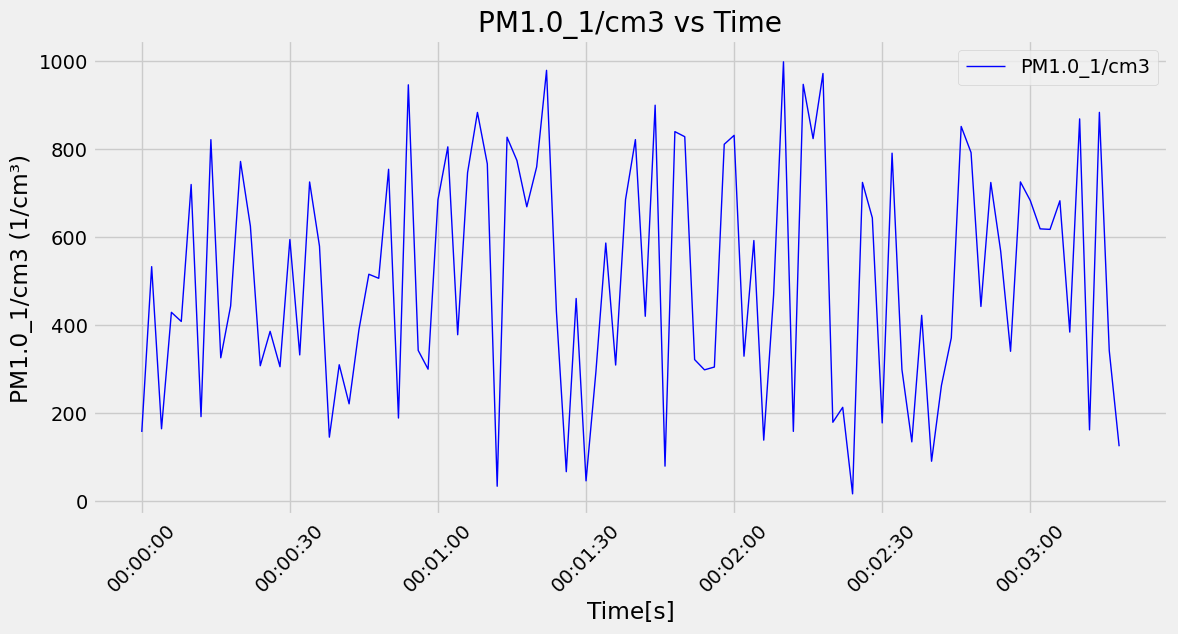

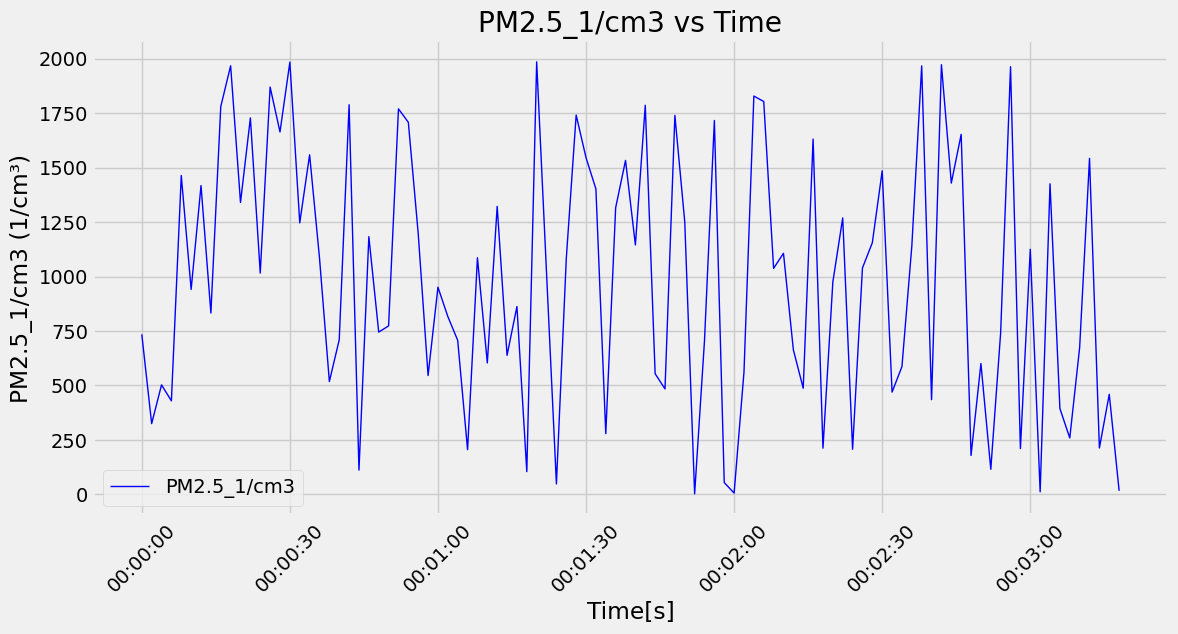

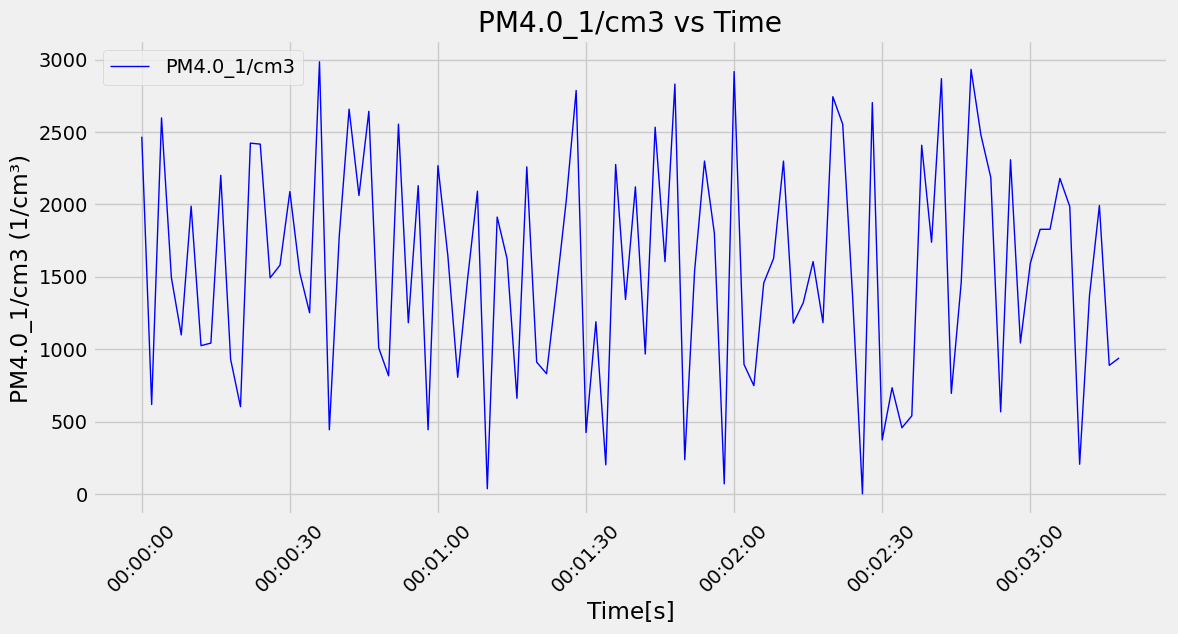

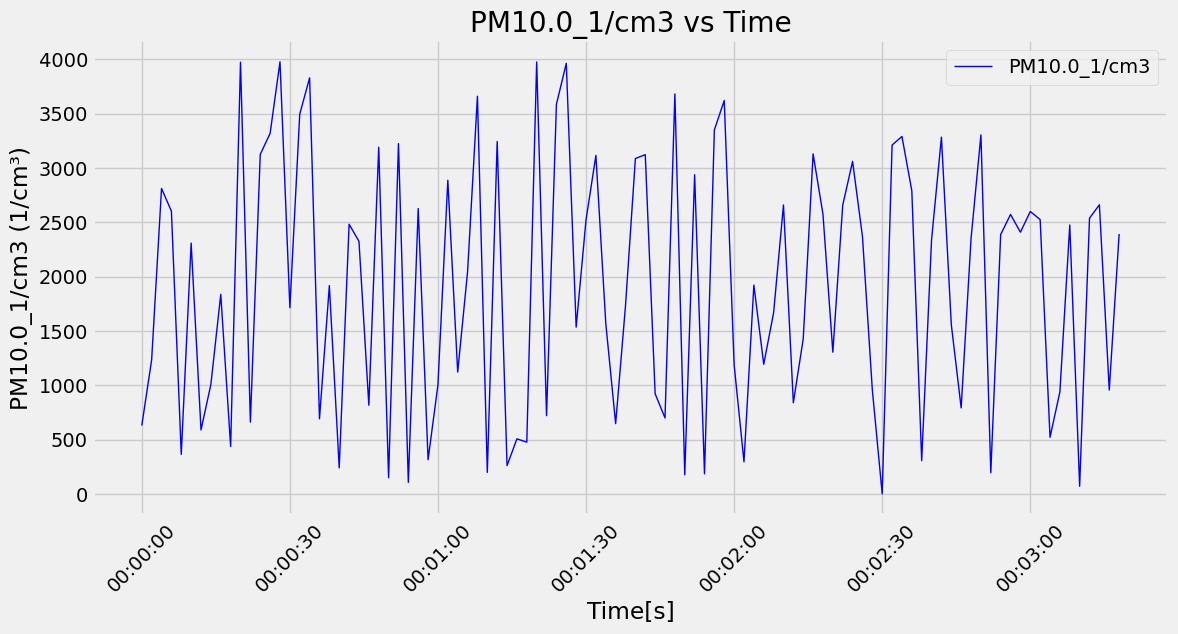

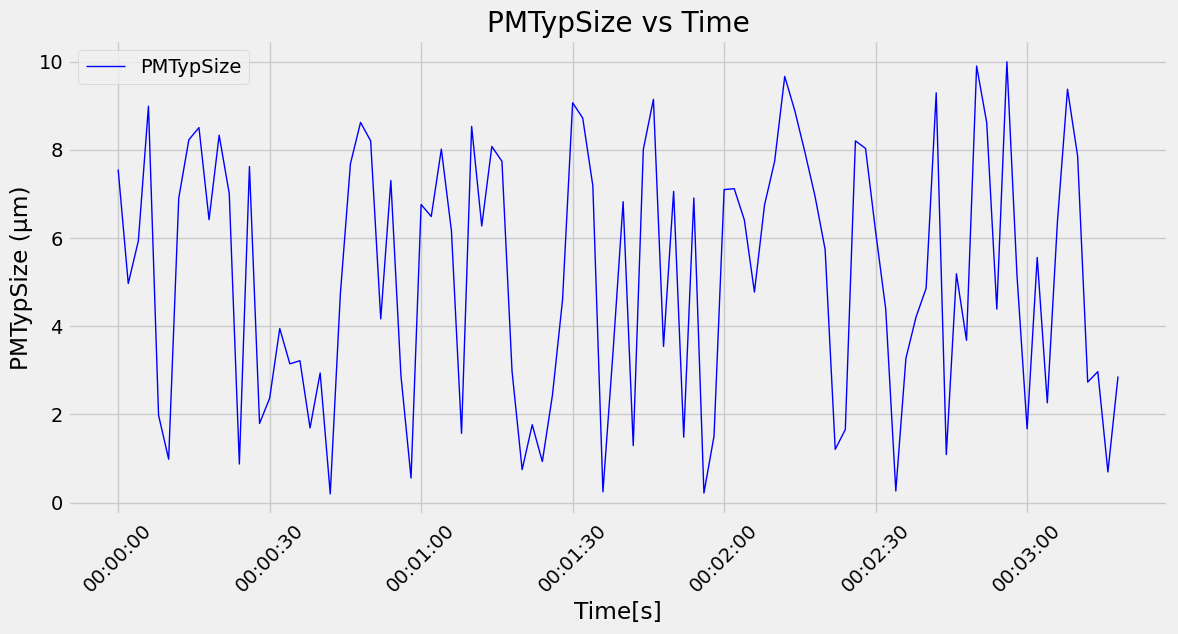

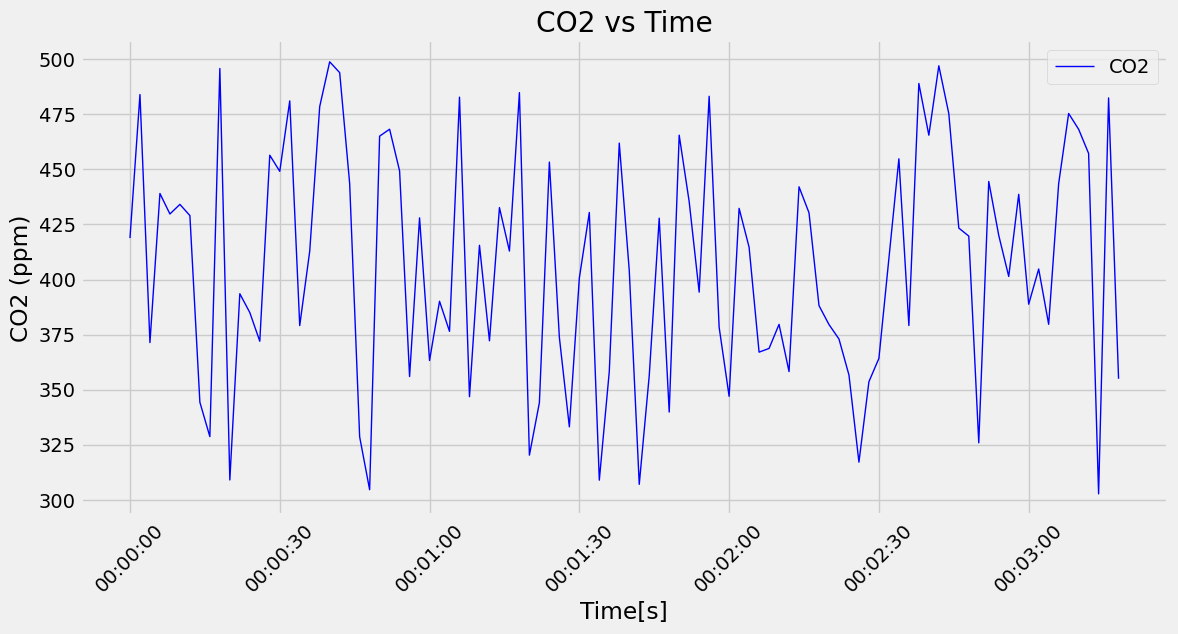

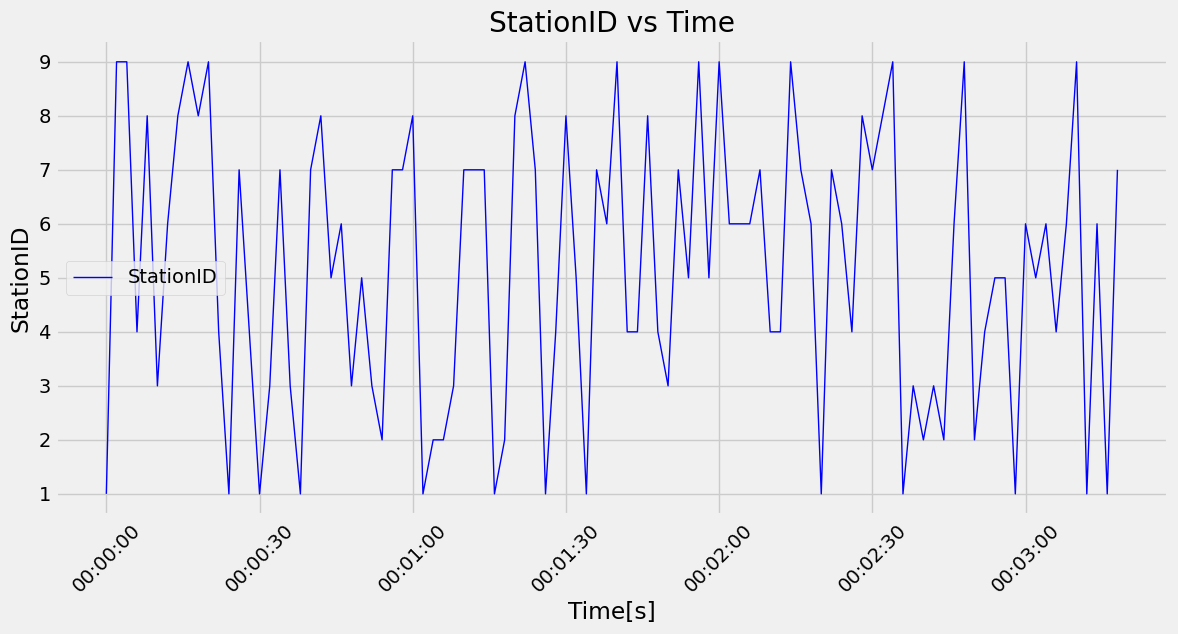

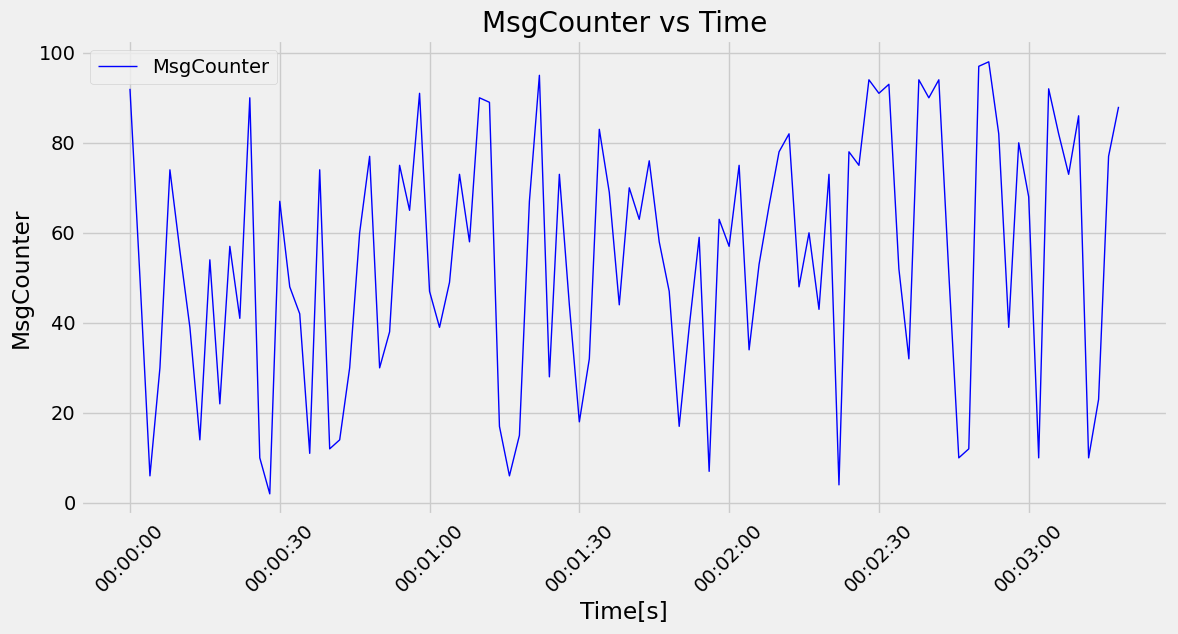

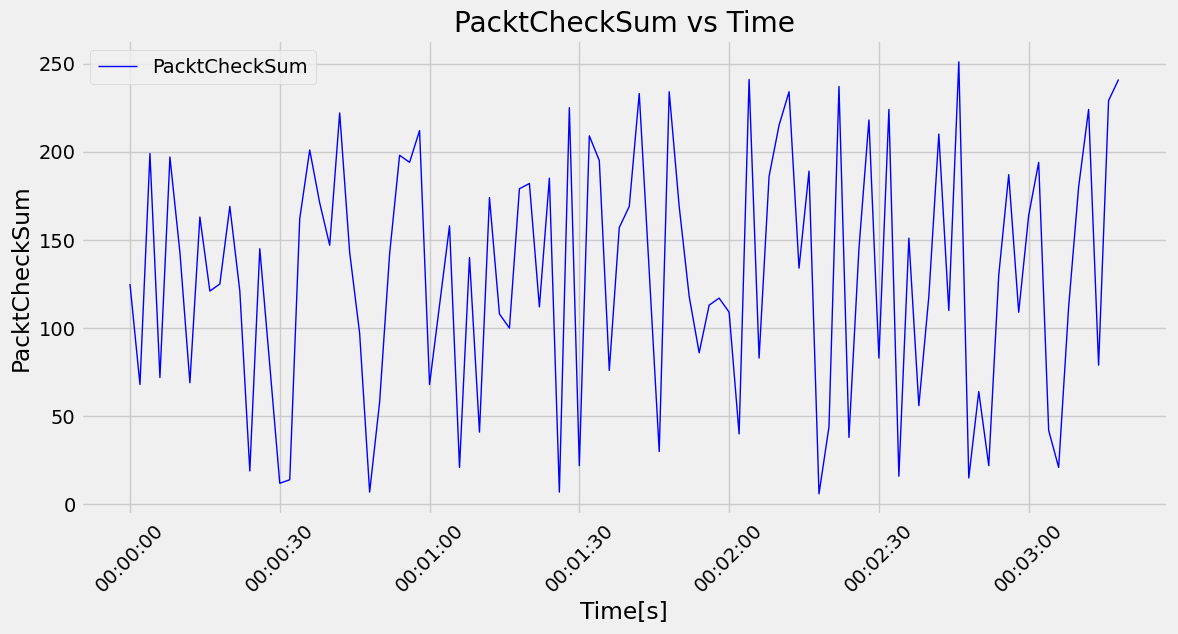

In [204]:
display_time_series(0, 100)

C:\Users\ohm_r\anaconda3\envs\py310\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


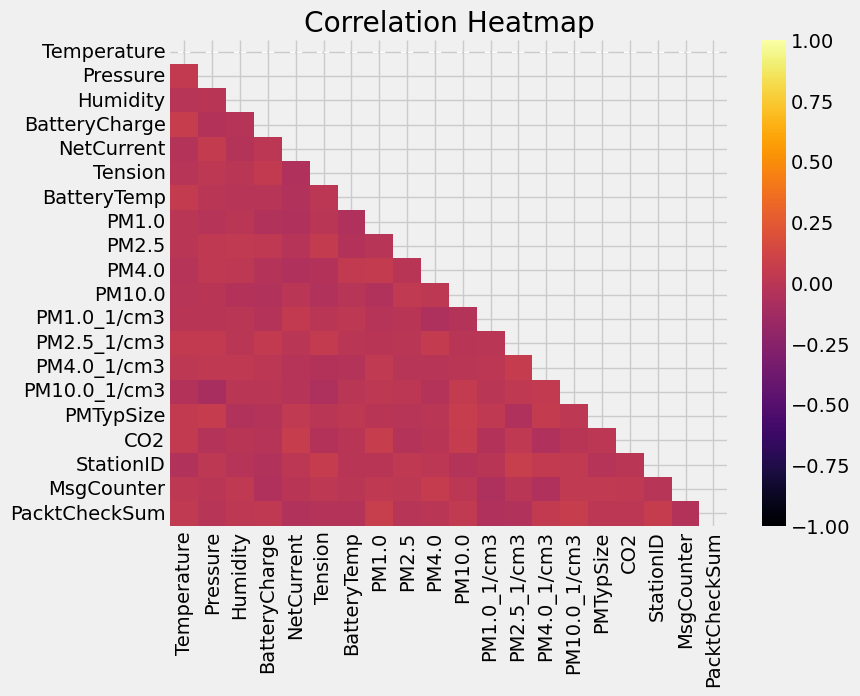

In [205]:
# For now correlation is unclear. We will wait for real data to understand anything relavant
display_heatmap('inferno')

### Add more viz and analysis soon once real data is gathered